# Programming Z3 - a tutorial

## Outline

* Using Z3 from Python
* SAT in a nutshell 
* Example Sudoko - model enumeration
* SMT: EUF, Arrays, Partial Orders, Arithmetic; quantifiers
* Services: Unsat cores, Optimization, Consequences
* Control: Parameters, Tactics, Parallelization

## Using Z3 from Python

In [1]:
!pip install "z3-solver"
from z3 import *

     |████████████████████████████████| 19.3MB 4.4kB/s eta 0:00:01    |██████                          | 3.6MB 2.7MB/s eta 0:00:06��██▋             | 11.2MB 1.6MB/s eta 0:00:06     |██████████████████▉             | 11.4MB 1.6MB/s eta 0:00:06     |█████████████████████▊          | 13.1MB 1.3MB/s eta 0:00:05


# Z3 - a bird's eye view

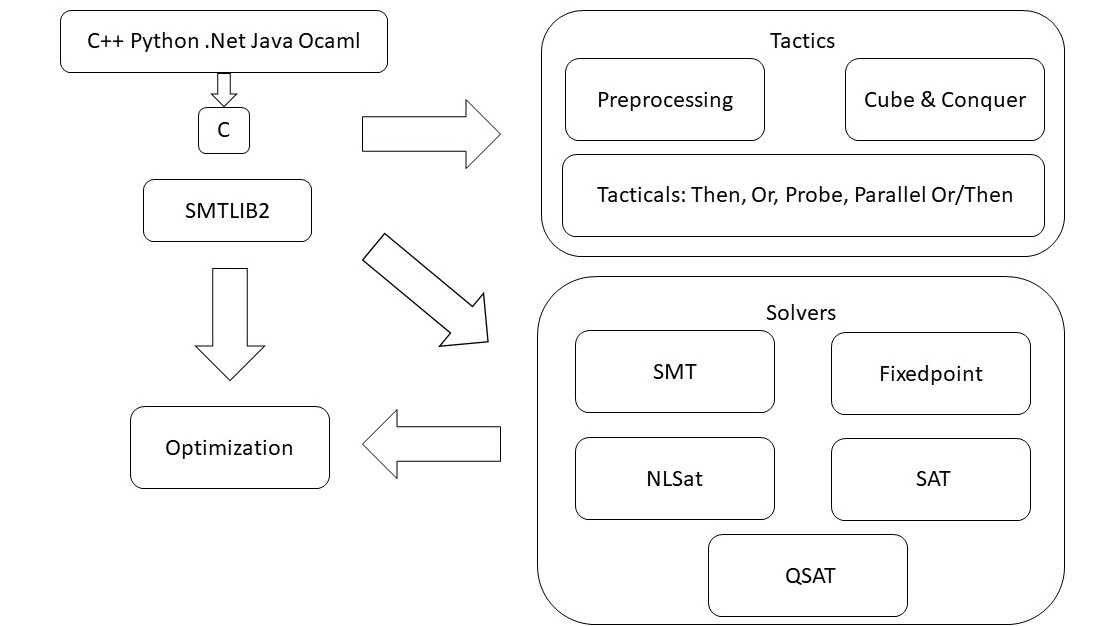

## SAT in a nutshell

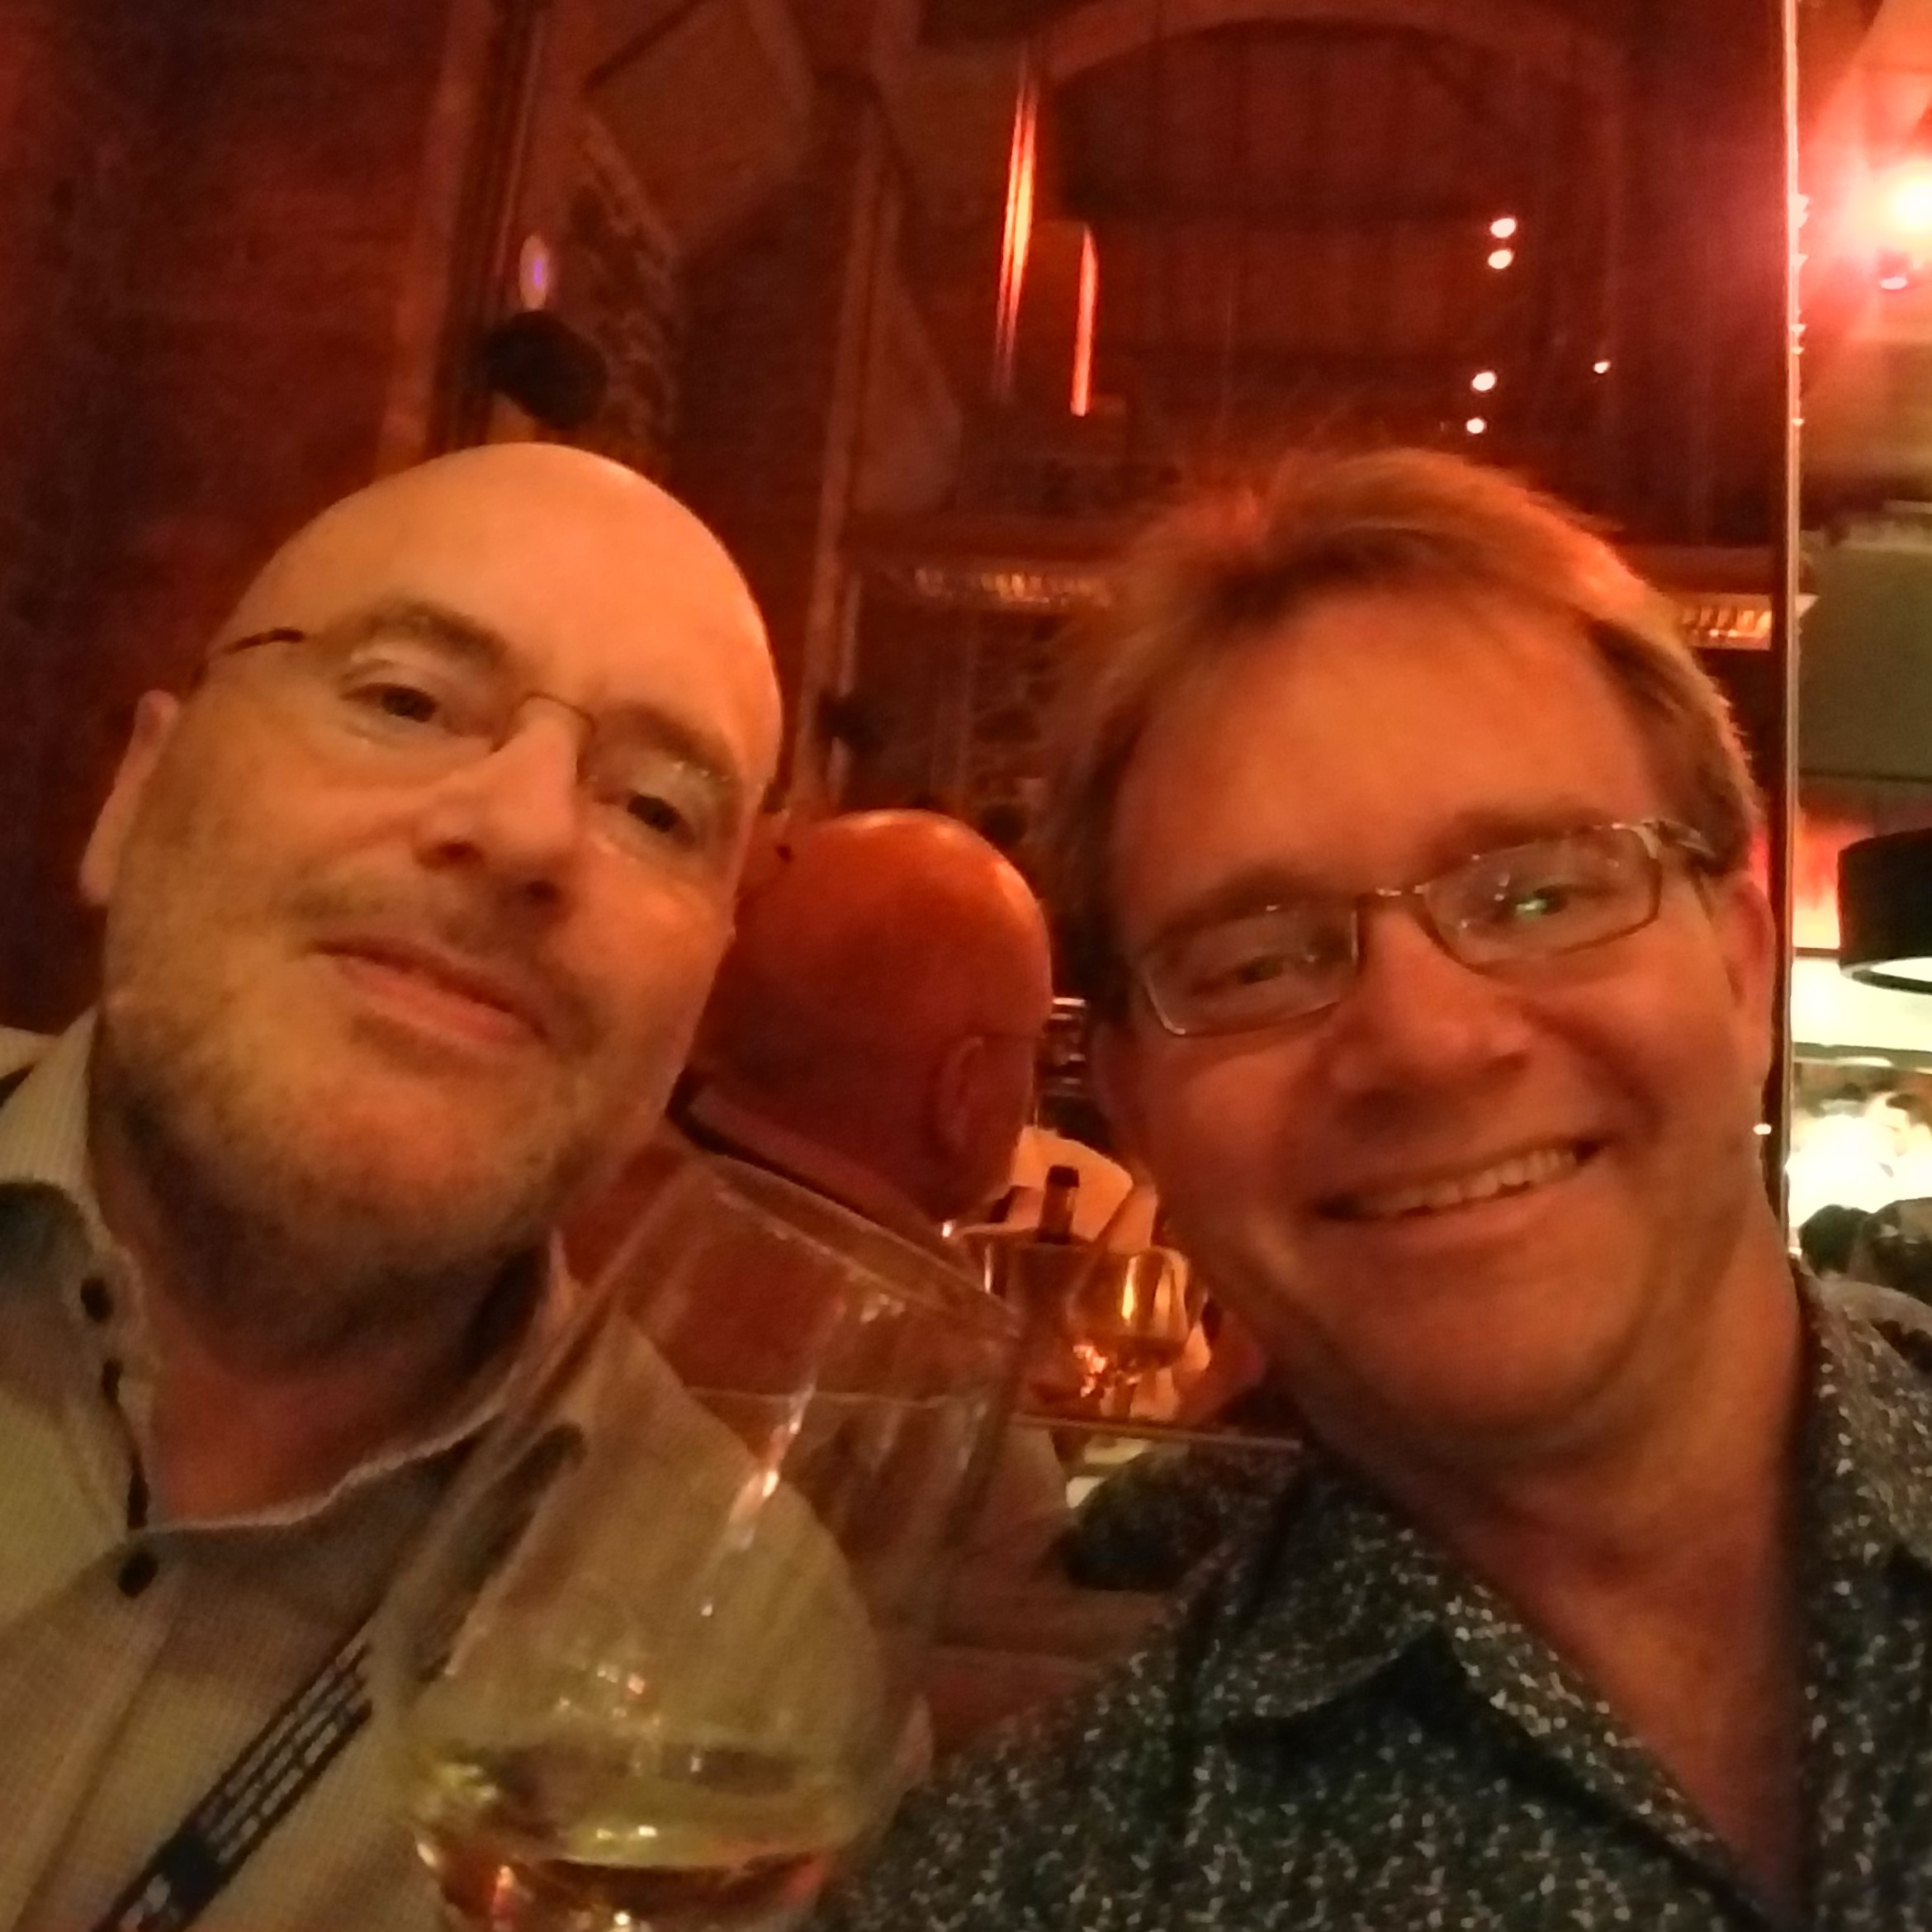

In [2]:
Tie, Shirt = Bools('Tie Shirt')
s = Solver()
s.add(Or(Tie, Shirt), Implies(Tie, Shirt), Implies(Shirt, Not(Tie)))
print(s.check())
print(s.model())

sat
[Tie = False, Shirt = True]


## Example - Sudoko

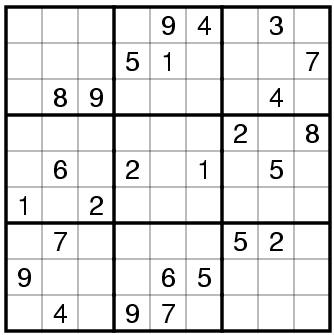

In [3]:
# sudoku instance, we use '0' for empty cells
instance = ((0,0,0,0,9,4,0,3,0),
            (0,0,0,5,1,0,0,0,7),
            (0,8,9,0,0,0,0,4,0),
            (0,0,0,0,0,0,2,0,8),
            (0,6,0,2,0,1,0,5,0),
            (1,0,2,0,0,0,0,0,0),
            (0,7,0,0,0,0,5,2,0),
            (9,0,0,0,6,5,0,0,0),
            (0,4,0,9,7,0,0,0,0))

In [4]:
 # 9x9 matrix of integer variables
X = [ [ Int("x_%s_%s" % (i+1, j+1)) for j in range(9) ]
      for i in range(9) ]

# each cell contains a value in {1, ..., 9}
cells_c  = [ And(1 <= X[i][j], X[i][j] <= 9)
             for i in range(9) for j in range(9) ]

# each row contains a digit at most once
rows_c   = [ Distinct(X[i]) for i in range(9) ]

# each column contains a digit at most once
cols_c   = [ Distinct([ X[i][j] for i in range(9) ])
             for j in range(9) ]

# each 3x3 square contains a digit at most once
sq_c     = [ Distinct([ X[3*i0 + i][3*j0 + j]
                        for i in range(3) for j in range(3) ])
             for i0 in range(3) for j0 in range(3) ]

sudoku_c = cells_c + rows_c + cols_c + sq_c

Cells in the *instance* that have non-zero values are fixed. 

In [5]:
instance_c = [ X[i][j] == instance[i][j] for i in range(9) for j in range(9) if not (instance[i][j] == 0) ]


### Solvers
Add *sudoko_c* constraints and *instance_c* to a solver

* Create a Solver
* Add constraints to a solver
* Extract a model
* Evaluate values in a model

In [6]:
s = Solver()
s.add(sudoku_c + instance_c)
if s.check() == sat:
    m = s.model()
    r = [ [ m.evaluate(X[i][j]) for j in range(9) ]
          for i in range(9) ]
    print_matrix(r)
else:
    print("failed to solve")

[[7, 1, 5, 8, 9, 4, 6, 3, 2],
 [2, 3, 4, 5, 1, 6, 8, 9, 7],
 [6, 8, 9, 7, 2, 3, 1, 4, 5],
 [4, 9, 3, 6, 5, 7, 2, 1, 8],
 [8, 6, 7, 2, 3, 1, 9, 5, 4],
 [1, 5, 2, 4, 8, 9, 7, 6, 3],
 [3, 7, 6, 1, 4, 8, 5, 2, 9],
 [9, 2, 8, 3, 6, 5, 4, 7, 1],
 [5, 4, 1, 9, 7, 2, 3, 8, 6]]


### Multiple solutions

* Turning values from a model into constraints
* You can incrementally add constraints to a solver

In [7]:
# Let us remove 9 from the first row and see if there is more than one solution

instance = ((0,0,0,0,0,4,0,3,0),
            (0,0,0,5,1,0,0,0,7),
            (0,8,9,0,0,0,0,4,0),
            (0,0,0,0,0,0,2,0,8),
            (0,6,0,2,0,1,0,5,0),
            (1,0,2,0,0,0,0,0,0),
            (0,7,0,0,0,0,5,2,0),
            (9,0,0,0,6,5,0,0,0),
            (0,4,0,9,7,0,0,0,0))

instance_c = [ If(instance[i][j] == 0,
                  True,
                  X[i][j] == instance[i][j])
               for i in range(9) for j in range(9) ]    
    
def n_solutions(n):
    s = Solver()
    s.add(sudoku_c + instance_c)
    count = 0
    while s.check() == sat and count < n:
        m = s.model()
        print(count)
        for i in range(9):
            print([ m.evaluate(X[i][j]) for j in range(9)])
        print("\n")
        fml = And([X[i][j] == m.evaluate(X[i][j]) for i in range(9) for j in range(9)])
        s.add(Not(fml))
        count += 1
        
n_solutions(10)



0
[6, 1, 7, 8, 2, 4, 9, 3, 5]
[2, 3, 4, 5, 1, 9, 6, 8, 7]
[5, 8, 9, 6, 3, 7, 1, 4, 2]
[7, 9, 3, 4, 5, 6, 2, 1, 8]
[4, 6, 8, 2, 9, 1, 7, 5, 3]
[1, 5, 2, 7, 8, 3, 4, 9, 6]
[3, 7, 6, 1, 4, 8, 5, 2, 9]
[9, 2, 1, 3, 6, 5, 8, 7, 4]
[8, 4, 5, 9, 7, 2, 3, 6, 1]


1
[5, 1, 7, 6, 8, 4, 9, 3, 2]
[2, 3, 4, 5, 1, 9, 6, 8, 7]
[6, 8, 9, 3, 2, 7, 1, 4, 5]
[4, 9, 3, 7, 5, 6, 2, 1, 8]
[7, 6, 8, 2, 9, 1, 3, 5, 4]
[1, 5, 2, 4, 3, 8, 7, 9, 6]
[8, 7, 6, 1, 4, 3, 5, 2, 9]
[9, 2, 1, 8, 6, 5, 4, 7, 3]
[3, 4, 5, 9, 7, 2, 8, 6, 1]


2
[5, 1, 6, 7, 8, 4, 9, 3, 2]
[2, 3, 4, 5, 1, 9, 6, 8, 7]
[7, 8, 9, 6, 2, 3, 1, 4, 5]
[4, 9, 7, 3, 5, 6, 2, 1, 8]
[8, 6, 3, 2, 9, 1, 7, 5, 4]
[1, 5, 2, 8, 4, 7, 3, 9, 6]
[6, 7, 1, 4, 3, 8, 5, 2, 9]
[9, 2, 8, 1, 6, 5, 4, 7, 3]
[3, 4, 5, 9, 7, 2, 8, 6, 1]


3
[5, 1, 6, 7, 8, 4, 9, 3, 2]
[2, 3, 4, 5, 1, 9, 6, 8, 7]
[7, 8, 9, 3, 2, 6, 1, 4, 5]
[4, 9, 7, 6, 5, 3, 2, 1, 8]
[8, 6, 3, 2, 9, 1, 7, 5, 4]
[1, 5, 2, 8, 4, 7, 3, 9, 6]
[6, 7, 1, 4, 3, 8, 5, 2, 9]
[9, 2, 8, 1, 6, 5, 4, 7, 3]
[3, 4,


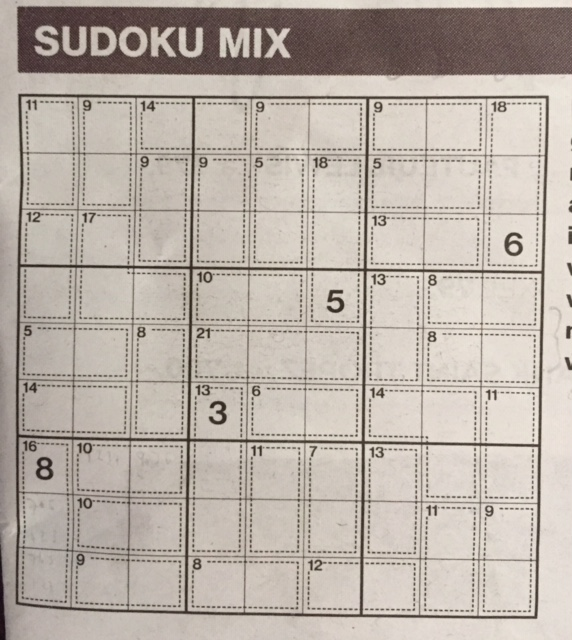

https://github.com/PKHG/doc/blob/master/3x9%20Mix%20Sudoku%20Solved%20Tubantia%205%20juni.ipynb


https://yurichev.com/writings/SAT_SMT_by_example.pdf

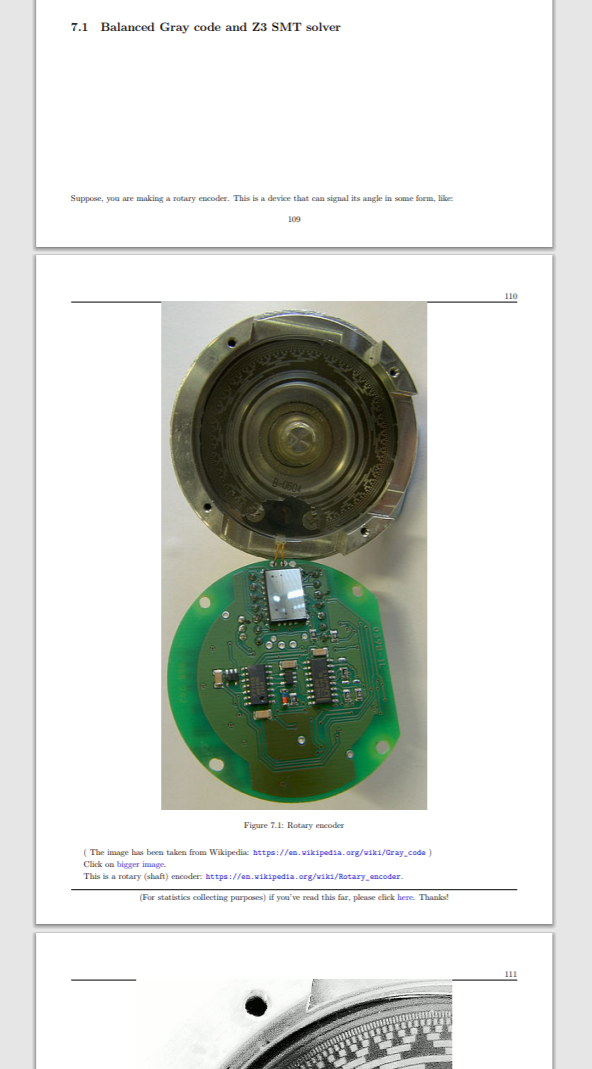

## SMT in a nutshell

* Integer sort declaration
* Function declaration
* Integer constant declaration
* *prove* command

In [8]:
  Z = IntSort()
  f = Function('f', Z, Z)
  x, y = Ints('x y')
  A = Array('A',Z,Z)
  fml = Implies(x + 2 == y, f(Store(A, x, 3)[y - 2]) == f(y - x + 1))
  prove(fml)

proved


What is *prove* ?

* A formula *fml* is valid if and only if *Not(fml)* is unsatisfiable

In [9]:
def my_prove(claim):
    s = Solver()
    s.add(Not(claim))
    r = s.check()
    if r == unsat:
        print("proved!!!")
    elif r == unknown:
        print("failed to prove")
        print(s.model())
    else:
        print("counterexample")
        print(s.model())
        
my_prove(fml)

proved!!!


## What is the theory of uninterpreted functions?

* Union-find
* Congruence closure

In [10]:
  S = DeclareSort('S')
  f = Function('f', S, S)
  x = Const('x', S)
  solve(f(f(x)) == x, f(f(f(x))) == x)

[x = S!val!0, f = [else -> S!val!0]]


Conventions:

* S is a free sort.
* f is a free unary function from S to S.
* x is a free constant of sort S.

The conjunction _f(f(x)) = x, f(f(f(x)) = x_ is satisfiable.

Union of equal terms:

* { _x, f(f(x)),  f(f(f(x))_}

Union find maintains equivalence classes


Then by congruence closure:

* _f(f(x)) = x_ implies _f(f(f(x)) = f(x)_

New congruence class

* { _x, f(x), f(f(x)), f(f(f(x))_ }


Congruence closure algorithm recovers equal children under _f(f(f(x))_ and _f(x)_

Implied congruences

* { _x, f(x), f(f(x)), f(f(f(x)), f(f(f(f(x))), f(f(f(f(f(x))))), ..._ }


In [11]:
  solve(f(f(x)) == x, f(f(f(x))) == x, f(x) != x)

no solution


## What is the theory of arrays?

In [13]:
#  A = Array(Index, Elem) # array sort 
#  
#  a[i]             # index array 'a' at index 'i'
#                   # Select(a, i)
#  
#  Store(a, i, v)   # update array 'a' with value 'v' at index 'i'
#                   # = lambda j: If(i == j, v, a[j])
#    
#  Const(v, A)      # constant array
#                   # = lambda j: v
#  
#  Map(f, a)        # map function 'f' on values of 'a'
#                   # = lambda j: f(a[j])
#
#  Ext(a, b)        # Extensionality
#                   # Implies(a[Ext(a, b)] == b[Ext(a, b)], a == b)

Example `Store(a, i, v)`    

* Each occurrence of `Store(a, i, v)` and `b[j]` in quantifier-free Solver assertions.
   * Assert `Store(a, i, v)[j] == If(i == j, v, a[j])`
   * Assert `Store(a, i, v)[i] == v`
   
   
* Each shared occurrences of $a, b$: 
   * Assert $a[\mbox{Ext}(a, b)] = b[\mbox{Ext}(a,b)] \ \implies \ a = b$.



* Suppose we are given a model $M$ satisfying all asserted equalities in Solver.
   * $M$ assigns values to $a[i]\in \mathcal{T}$ terms.
   * Extend: $M(a) := \left[ M(i) \mapsto M(a[i])\; \mid\; a[i] \in \mathcal{T}; \ \mbox{else}\ \mapsto \diamond_{\mbox{default}} \right]$
   * __Claim__: $M(a)$ satisfies `Store` axioms.

### Sharing Equalities

Recall:
* Each shared occurrences of $a, b$: 
   * Assert $a[\mbox{Ext}(a, b)] = b[\mbox{Ext}(a,b)] \ \implies \ a = b$.
   

What happens if we don't add this axiom?

* Hint $M(a) := \left[ M(i) \mapsto M(a[i])\; \mid\; a[i] \in \mathcal{T}; \ \mbox{else}\ \mapsto \diamond_{\mbox{default}} \right]$

### Sharing Equalities - Combining Theories

In practice, we need a combination of theories.


* $b + 2 = c  \wedge  f(Select(Store(a,b,3), c-2)) \neq f(c-b+1)$

A theory is a set (potentially infinite) of first-order sentences.

Main questions:
  * Is the union of two theories $T_1 \cup T_2$ consistent?
  * Given a solvers for $T_1$ and $T_2$, 
    how can we build a solver for $T_1 \cup T_2$?


### Disjoint Theories

* Two theories are disjoint if they do not share function/constant and predicate symbols.
$=$ is the only exception.

* Example:

  * The theories of arithmetic and arrays are disjoint.
 
  * Arithmetic symbols: $\{0, -1, 1, -2, 2, \ldots, +, -, \times, >, <,  =, \geq \}$.
  * Array symbols: $\{ Select, Store \}$


### Combining Disjoint Theories

* To check satisfiability of conjunction $\Gamma$, split into theory disjoint parts


* $\Gamma := \Gamma_1 \wedge \Gamma_2 \wedge x = y \wedge y \neq z \wedge x \neq z$


* Equalities and disequalities on common variables are _shared_ between $\Gamma_1, \Gamma_2$.

### Stably infinite Theories

* A theory is stably infinite if every satisfiable QFF is satisfiable in an infinite model.


* EUF and arithmetic are stably infinite.


* Bit-vectors are not
 

### Nelson-Oppen combination

Let $\mathcal{T}_1$ and $\mathcal{T}_2$ be consistent, stably infinite theories
over disjoint (countable) signatures. Assume satisfiability of conjunction of
literals can be decided in $O(\mathcal{T}_1(n))$ and
$O(\mathcal{T}_2(n))$ time respectively.
Then

1. The combined theory $\mathcal{T}$ is consistent and stably infinite.


2. Satisfiability of quantifier free conjunction of literals can be decided
in $O(2^{n^2} \times (\mathcal{T}_1(n) + \mathcal{T}_2(n)))$.


3. If $\mathcal{T}_1$ and $\mathcal{T}_2$ are consistent, then so is
$\mathcal{T}$ and satisfiability in $\mathcal{T}$ is
in $O(n^3 \times (\mathcal{T}_1(n) + \mathcal{T}_2(n)))$.


### Purification

$
   \color{red}{b + 2 = c},\ \color{blue}{f}(\color{green}{Select}(\color{green}{Store}\color{red}{(a,b,3), c-2})) \neq \color{blue}{f}(\color{red}{c-b+1})
$


becomes

$
\begin{array}{ll}
  \mathrm{Arithmetic:} & \color{red}{b + 2 + c, v_2 \equiv c - b + 1, v_4 \equiv c-2,  v_5 \equiv 2}\\[2em]
  \mathrm{EUF:}        & \color{blue}{f(v_1) \neq f(v_2)}\\[2em]
  \mathrm{Arrays:}     & \color{green}{v_1 \equiv Select(v_3, v_4), v_3 \equiv Store(a,b,v_5)}
\end{array}
$


### Combining Theories in Practice (Model based)


* Suppose $M_i \models \Gamma_i \cup \mathcal{T}_i$

* Guess equalities implied by $M_i$: 
    
    * If $M_i \models \mathcal{T}_i \cup \Gamma_i \cup \{ u = v \}$ then guess $u = v$

* Backtrack on guesses that disagree with other theories.



## SMT Architecture

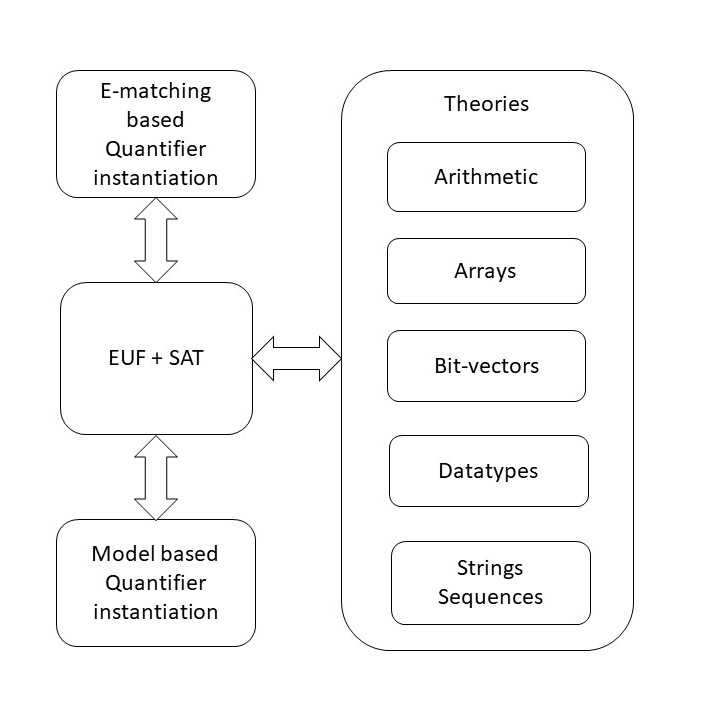


## SMT Theories

* Uninterpreted functions
* Arithmetic
* Arrays
* Bit-vectors
* IEEE floating point numbers
* Algebraic Datatypes
* Sequences/Strings
* Partial Orders
* Transitive Relations


* Quantification


## Decision Procedure Integration - Architecture

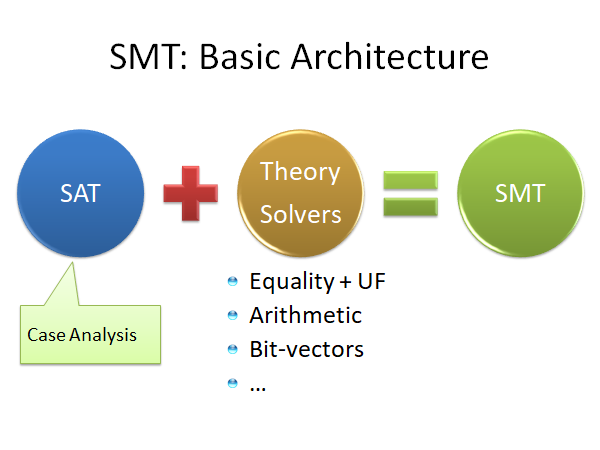

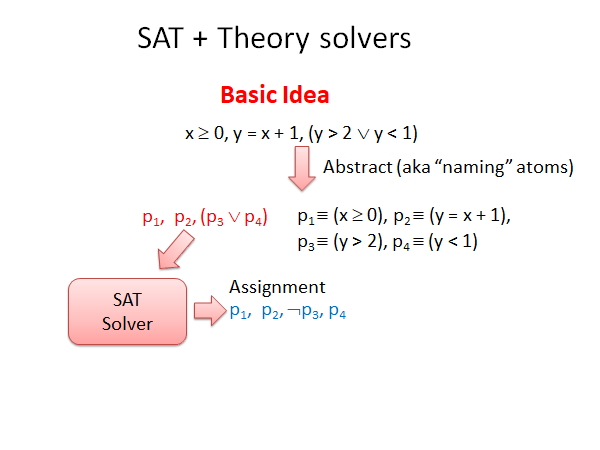

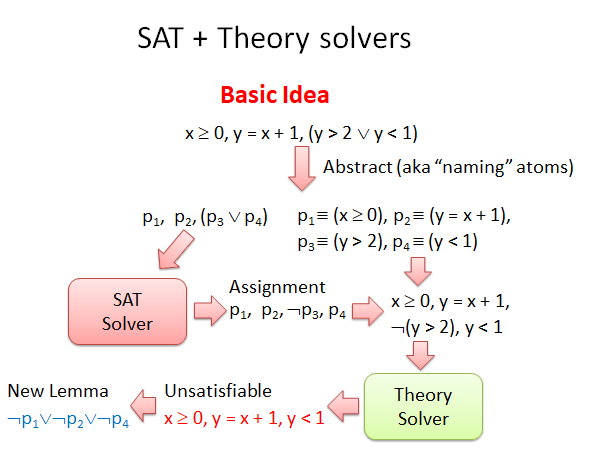

## Special Relations

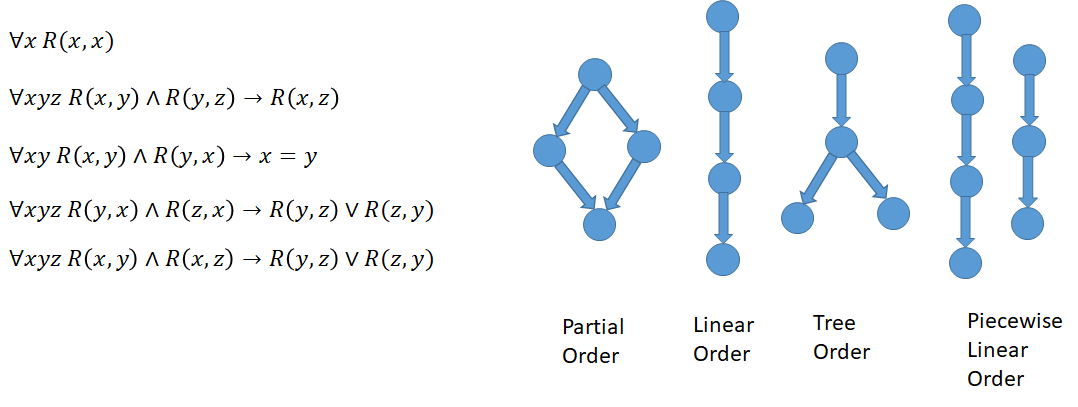

### Reasoning using quantified axioms.

* Check if conjunction of quantifier free literals is SAT modulo Ordering Axioms with resolution/instantiation

* quadratic space/time.

In [12]:
s = Solver()
A = DeclareSort("A")
B = BoolSort()
R = Function('R', A, A, B)
x, y, z, a, b, c, d = Consts('x y z a b c d', A)
s.add(ForAll([x], R(x, x)))  
s.add(ForAll([x,y], Implies(And(R(x, y), R(y, x)), x == y)))
s.add(ForAll([x,y,z], Implies(And(R(x, y), R(y, z)), R(x, z))))
   
s.add(R(a,b), R(a,c), Not(R(b,c)), Not(R(c,b)))
print(s.check())
print(s.model())

sat
[b = A!val!1,
 a = A!val!0,
 c = A!val!2,
 R = [else ->
      Or(And(If(Var(0) == A!val!2,
                A!val!2,
                If(Var(0) == A!val!0, A!val!0, A!val!1)) ==
             A!val!1,
             If(Var(1) == A!val!2,
                A!val!2,
                If(Var(1) == A!val!0, A!val!0, A!val!1)) ==
             A!val!1),
         And(If(Var(0) == A!val!2,
                A!val!2,
                If(Var(0) == A!val!0, A!val!0, A!val!1)) ==
             A!val!0,
             If(Var(1) == A!val!2,
                A!val!2,
                If(Var(1) == A!val!0, A!val!0, A!val!1)) ==
             A!val!1),
         And(If(Var(0) == A!val!2,
                A!val!2,
                If(Var(0) == A!val!0, A!val!0, A!val!1)) ==
             A!val!2,
             If(Var(1) == A!val!2,
                A!val!2,
                If(Var(1) == A!val!0, A!val!0, A!val!1)) ==
             A!val!2),
         And(If(Var(0) == A!val!2,
                A!val!2,
                If(Var(0)

In [13]:
s.add(R(b,d))
s.add(Not(R(a,d)))
print(s.check())


unsat


### Model-based Quantifier Instantiation Algorithm

$\psi \land \forall x \ . \ \varphi[{x}]$

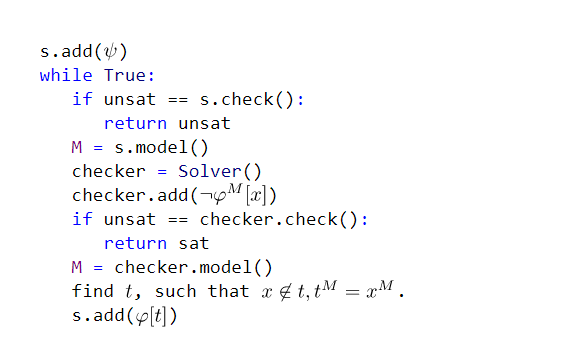

In [14]:
s = Solver()
lots_of_as = Consts(["a%d" % i for i in range(10)], A)
for i in range(9):
    s.add(R(lots_of_as[i], lots_of_as[i+1]))
s.add(ForAll([x], R(x, x)))  
s.add(ForAll([x,y], Implies(And(R(x, y), R(y, x)), x == y)))
s.add(ForAll([x,y,z], Implies(And(R(x, y), R(y, z)), R(x, z))))    
print(s.check())
print(s.model())

sat
[a4 = A!val!4,
 a2 = A!val!2,
 a7 = A!val!7,
 a1 = A!val!1,
 a0 = A!val!0,
 a6 = A!val!6,
 a9 = A!val!9,
 a8 = A!val!8,
 a5 = A!val!5,
 a3 = A!val!3,
 R = [else ->
      Or(And(k!56(Var(0)) == A!val!0,
             k!56(Var(1)) == A!val!5),
         And(k!56(Var(0)) == A!val!0,
             k!56(Var(1)) == A!val!6),
         And(k!56(Var(0)) == A!val!3,
             k!56(Var(1)) == A!val!9),
         And(k!56(Var(0)) == A!val!4,
             k!56(Var(1)) == A!val!9),
         And(k!56(Var(0)) == A!val!1,
             k!56(Var(1)) == A!val!6),
         And(k!56(Var(0)) == A!val!1,
             k!56(Var(1)) == A!val!1),
         And(k!56(Var(0)) == A!val!0,
             k!56(Var(1)) == A!val!7),
         And(k!56(Var(0)) == A!val!6,
             k!56(Var(1)) == A!val!6),
         And(k!56(Var(0)) == A!val!0,
             k!56(Var(1)) == A!val!4),
         And(k!56(Var(0)) == A!val!5,
             k!56(Var(1)) == A!val!6),
         And(k!56(Var(0)) == A!val!6,
             k!56(Var(1)


### Reasoning with specialized decision procedures

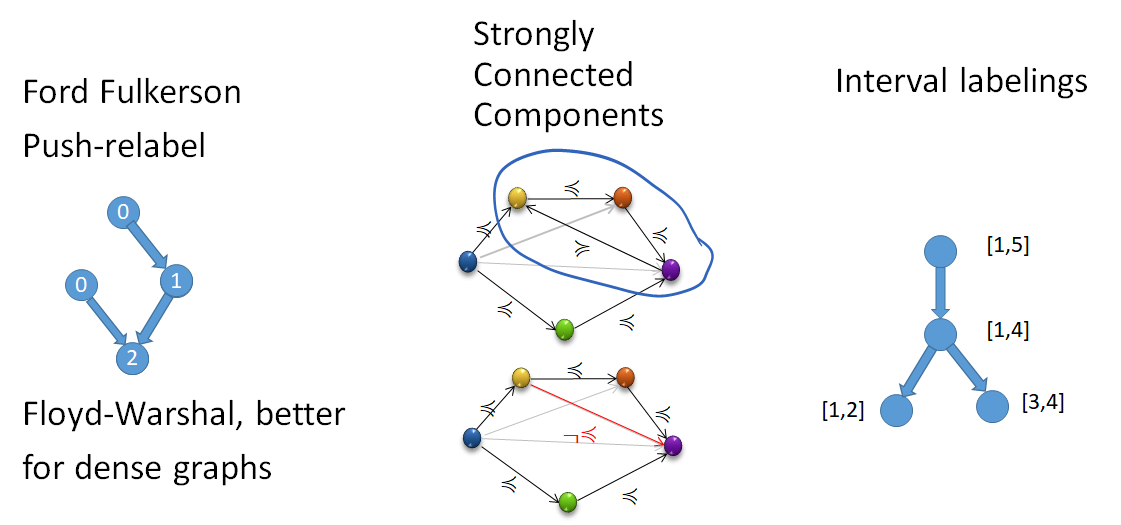

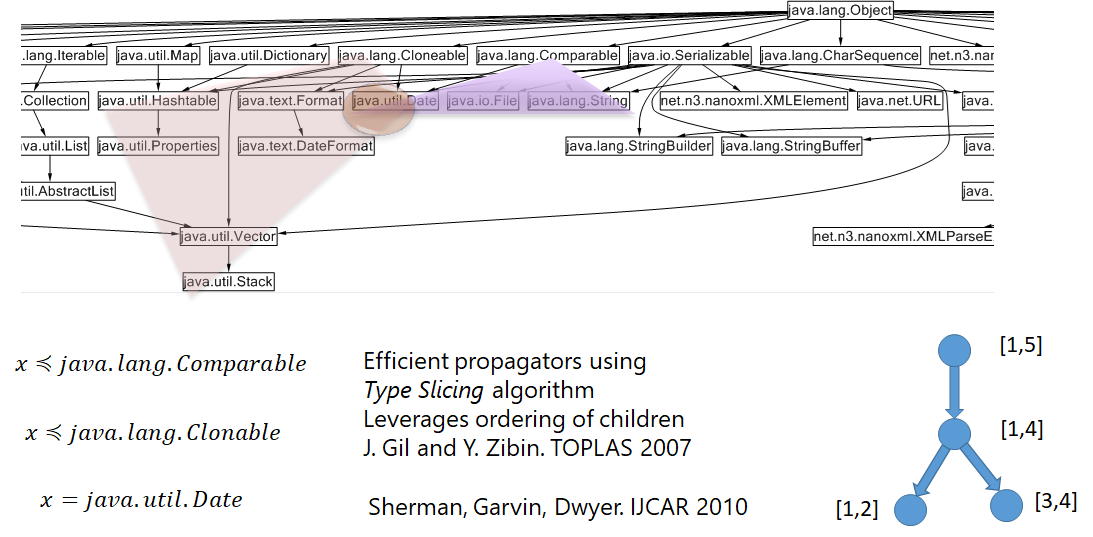

## Models for special relations

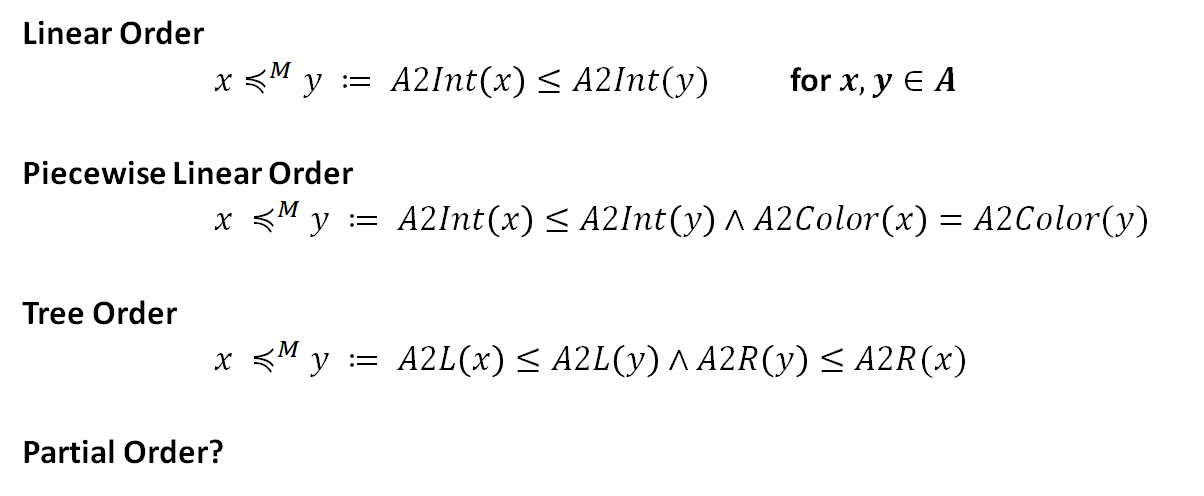

## Arithmetic

In [15]:
x, y = Reals('x y')
solve([x >= 0, Or(x + y <= 2, x + 2*y >= 6), Or(x + y >= 2, x + 2*y > 4)])

[y = 2, x = 0]



Z3 introduces auxiliary variables $s_1, s_2$ and represents the formula as

$
  s_1 \equiv x + y, s_2 \equiv x + 2y,
  x \geq 0, (s_1 \leq 2 \vee s_2 \geq 6), (s_1 \geq 2 \vee s_2 > 4)
$ 

Only bounds (e.g., $s_1 \leq 2$) are asserted during search.

In [16]:
x, y, s1, s2 = Reals('x y s1 s2')
solve([s1 == x + y, s2 == x + 2*y, x >= 0, Or(s1 <= 2, s2 >= 6), Or(s1 >= 2, s2 > 4)])

[s2 = 6, y = 3, x = 0, s1 = 3]


Normal form:
$
{s_1} - x - y = 0, \   
{s_2} - x - 2y = 0
$  

where ${s_1, s_2}$ are basic (dependent) and $x, y$ are non-basic.

* Initial values: 
$x = y = s_1 = s_2 = 0$

* Bounds $x \geq 0, s_1 \leq 2, s_1 \geq 2$. 

* Then value of $s_1$ violates bound. Make $y$ basic:
$
{y} + x - s_1 = 0, \ {s_2} + x - 2s_1 = 0
$


* The new tableau updates the assignment of variables to
$x = 0, s_1 = 2, s_2 = 4, y = 2$. The resulting assignment
is a model for the original formula.

## Arithmetic Theories
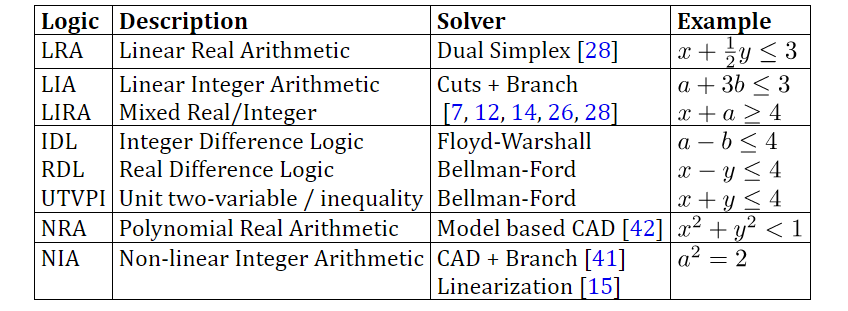

## Fragments of Arithmetic

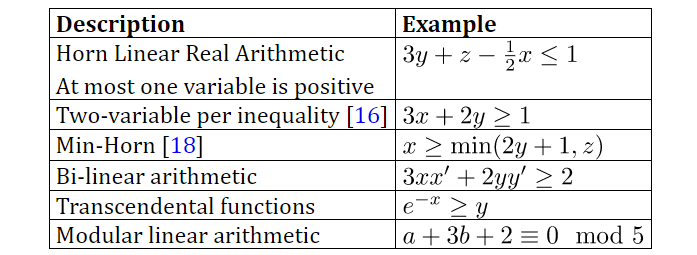

In [19]:
def is_power_of_two(x):
    return And(x != 0, 0 == (x & (x - 1)))
x = BitVec('x', 4)
prove(is_power_of_two(x) == Or([x == 2**i for i in range(4)]))

proved


The absolute value of a variable can be obtained using addition and xor with a sign bit.

In [20]:
v = BitVec('v',32)
mask = v >> 31
prove(If(v > 0, v, -v) == (v + mask) ^ mask)

proved


In [21]:
Tree = Datatype('Tree')
Tree.declare('Empty')
Tree.declare('Node', ('left', Tree), ('data', Z), ('right', Tree))
Tree = Tree.create()
t = Const('t', Tree)
solve(t != Tree.Empty)

[t = Node(Empty, 0, Empty)]


In [22]:
prove(t != Tree.Node(t, 0, t))

proved


In [23]:

x = FP('x', FPSort(3, 4))
y = FP('y', FPSort(3, 4))
solve(10 * x == y, x != 0)

[y = -0.0, x = -0.0]


In [24]:
s, t, u = Strings('s t u')
prove(Implies(And(PrefixOf(s, t), SuffixOf(u, t), 
                  Length(t) == Length(s) + Length(u)), 
             t == Concat(s, u)))


# One can concatenate single elements to a sequence as units:

s, t = Consts('s t', SeqSort(IntSort()))
solve(Concat(s, Unit(IntVal(2))) == Concat(Unit(IntVal(1)), t))
prove(Concat(s, Unit(IntVal(2))) != Concat(Unit(IntVal(1)), s))

proved
[s = Unit(1), t = Unit(2)]
proved


# Logical Services
* Unsat Cores
* Optimization
* Cube and Conquer
* Consequences

## Unsat Cores

In [25]:
p, q, r, v = Bools('p q r v')
s = Solver()
s.add(Not(q))
s.assert_and_track(q, p)
s.assert_and_track(r, v)
print(s.check())
print(s.unsat_core())

unsat
[p]


In [26]:
s = Solver()
s.add(Not(q))
s.add(Implies(p, q))
s.add(Implies(v, r))
print(s.check([p,v]))
print(s.unsat_core())

unsat
[p]


### Tracking literals

* Literals $p, v$ are asserted at level 1 before case split decisions.
* If the solver encounters a conflict at level 1, collect set of literals used in the conflict.

* Unsat core is not necessarily minimal.
   * s.set("sat.core.minimize","true")  - For Bit-vector theories
   * s.set("smt.core.minimize","true")  - For general SMT 
   
* Tracking literals prevent simplification, add overhead.
   * For SAT solver can use DRAT-trim to extract core


## Optimization

In [27]:
def tt(s, f):
    return is_true(s.model().eval(f))

def add_def(s, fml):
    name = Bool("%s" % fml)
    s.add(name == fml)
    return name

def relax_core(s, core, Fs):
    prefix = BoolVal(True)
    Fs -= { f for f in core }
    for i in range(len(core)-1):
        prefix = add_def(s, And(core[i], prefix))
        Fs |= { add_def(s, Or(prefix, core[i+1])) }

def maxsat(s, Fs):
    cost = 0
    Fs0 = Fs.copy()
    while unsat == s.check(Fs):
        cost += 1
        relax_core(s, s.unsat_core(), Fs)    
    return cost, { f for f in Fs0 if tt(s, f) }


In [28]:
s = Solver()
a, b, c, d = Bools('a b c d')
s.add(Or(a,b), Or(Not(a), Not(b)), Or(Not(c), Not(d), Not(a)))
cost, soln = maxsat(s, set([a,b,c,d]))
print(cost,soln)

1 {b, d, c}


Lemma: 
* The maxsat solution to Fs after relax_core is 1 + maxsat solution to original problem

Sketch: 
* Suppose $M$ evaluates $core := f_1, f_2, f_3, f_4, \ldots$, as $\top, \bot, \bot, \top, \top$.
* New Fs is of the form $f_1 \vee f_2, f_3 \vee (f_2 \wedge f_1), f_4 \vee (f_3 \wedge (f_2 \wedge f_1)), \ldots$
* Then $M$ evaluates $Fs$ as $\top, \bot, \top, \top, \ldots$
* First $i$, such that $F(f_i) = \bot$ is removed.

In [29]:
# Built-in optimization support

s = Optimize()
a, b, c, d = Bools('a b c d')
s.add(Or(a,b), Or(Not(a), Not(b)), Or(Not(c), Not(d), Not(a)))
s.add_soft(a)
s.add_soft(b)
s.add_soft(c)
s.add_soft(d)
print(s.check())
print(s.model())

sat
[a = False, b = True, c = True, d = True]


## Consequences

In [30]:
a, b, c, d = Bools('a b c d')

s = Solver()
s.add(Implies(a, b), Implies(c, d))   # background formula
print(s.consequences([a, c],          # assumptions
                     [b, c, d]))      # target literals: what is implied?


(sat, [Implies(c, c), Implies(a, b), Implies(c, d)])


### Algorithm

* Retrieve a model $M$ of solver state s.
* Prefer case split on target literals to be opposite of model $M$.
* If case split is conflicting, learn it as a backbone
* If a new model $M'$ is found, then remove target literal $a$ where $M(a) \neq M'(a)$.

# Control
* Tactics
* Parallelization
* (Configuration)

In [31]:
s = Tactic('qsat').solver()
Nat = Datatype('Nat')
Nat.declare('Z')
Nat.declare('S', ('pred', Nat))
Nat = Nat.create()
Z = Nat.Z
S = Nat.S
def move(x, y):
    return Or(x == S(y), x == S(S(y)))
def win(x, n):
    if n == 0:
        return False
    y = FreshConst(Nat)
    return Exists(y, And(move(x, y), Not(win(y, n - 1))))

s.add(win(S(S(S(S(Z)))), 3))
print(s.check())

sat


### QSAT

* Procedure for quantified formulas

* Uses 
  * Model based projection for backjumping
  * Strategies for forward prunings
  

### Model based projection

* Want to compute small $\exists x \ . \ (2y \leq x \wedge y - z \leq x \wedge x \leq z)$.


* Note $\equiv (y - z \leq 2y \leq z) \vee (2y \leq y - z \leq z)$


* Say $M = [x \mapsto 3, y \mapsto 1, z \mapsto 6]$


* $Mbp(M, x, 2y \leq x \wedge y - z \leq x \wedge x \leq z)$


* $(2y > y - z)^M = \top$ since $2y^M = 2$, $(y-z)^M = -5$


* $Mbp(M, x, 2y \leq x \wedge y - z \leq x \wedge x \leq z) = y - z \leq 2y \leq z$


* $y - z \leq 2y \leq z \ \Rightarrow \ \exists x \ . \ (2y \leq x \wedge y - z \leq x \wedge x \leq z)$



In [32]:
x, y = Reals('x y')
g  = Goal()
g.add(2 < x, Exists(y, And(y > 0, x == y + 2)))
print(g)

t1 = Tactic('qe-light')
t2 = Tactic('simplify')
t  = Then(t1, t2)
print(t(g))

[x > 2, Exists(y, And(y > 0, x == y + 2))]
[[Not(x <= 2)]]


### Parallelization

* parallel.enable=true configures default solvers to use Cube and Conquer mode.



### Cube and Conquer

* Use lookahead solver to find case split or set of case splits


In [33]:
Fs = []                    # Formula
s = SolverFor("QF_FD")     # Forces to use SAT backend, only applies to finite domain formulas
s.add(Fs)
s.set("sat.restart.max", 100)
def cube_and_conquer(s):
    for cube in s.cube():
       if len(cube) == 0:
          return unknown
       if is_true(cube[0]):
          return sat     
       is_sat = s.check(cube)
       if is_sat == unknown:
          s1 = s.translate(s.ctx)
          s1.add(cube)
          is_sat = cube_and_conquer(s1)
       if is_sat != unsat:
          return is_sat
    return unsat


# Some active areas

* Theory Solvers
  * Floating points, sequences/strings, regular languages
  * Non-linear arithmetic
  * _Boolean theories_
  * Inprocessing, pre-processing
  
* Quantifiers 
  * Horn clauses, QBF techniques and SMT
  
* Cube and conquer ... and SMT
  * MIP branch and bound heuristics vs. lookahead heuristics
  
* Controlling search heuristics 
  * Learn priorities on clauses, branch variables

# Summary

* Programmatic Introduction to SMT and Z3

* Theories and solvers: Arithmetic, Arrays, Equalities/Functions

* Theory combination

* Quantifiers: Model-based instantiation, QSAT

* Cores, Models, (proofs not covered)